## Packages

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import os

import collections
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import print_noise_matrix
from cleanlab import baseline_methods
from cleanlab.latent_estimation import compute_confident_joint

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def acc_loss_plot(network):
    accuracy = network.history['accuracy']
    val_accuracy = network.history['val_accuracy']
    loss = network.history['loss']
    val_loss = network.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'c', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Lectura de les dades

In [3]:
print(tf. __version__)

2.6.0


In [4]:
os.getcwd()

'C:\\Users\\aidaf\\TFG'

In [5]:
data_dir = os.path.join(os.getcwd() + "\\reduced")
data_dir

'C:\\Users\\aidaf\\TFG\\reduced'

In [6]:
classes = os. listdir(data_dir)
print(classes)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [7]:
dades_Y = np.load('labels_reduced.npy')
dades_X = np.load('images_reduced.npy')

## Descripció de les dades

Dimensió: 

In [8]:
print('Dimensions de les dades : ', dades_X.shape, dades_Y.shape)

Dimensions de les dades :  (4500, 120, 120, 3) (4500,)


Nombre de classes i etiquetes: 

In [9]:
n_classes = len(classes)
print('Nombre de classes : ', n_classes)
print('Etiquetes de les classes : ', classes)

Nombre de classes :  5
Etiquetes de les classes :  ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Distribució de les classes: 

In [10]:
print("Distribució de les classes : ",collections.Counter(dades_Y))

Distribució de les classes :  Counter({0: 900, 3: 900, 1: 900, 4: 900, 2: 900})


## Methods to Standardize Research with Noisy Labels

In [11]:
noise_matrix = np.array([[.97,.03,0,0,0],
                         [.03,.97,0,0,0],
                         [0,0,.87,.01,.12],
                         [0,0,.02,.98,0],
                         [0,0,.08,0,.92]])

np.sum(noise_matrix,1) == 1

array([ True,  True,  True,  True,  True])

In [12]:
print_noise_matrix(noise_matrix)
np.random.seed(seed=1)
# Create the noisy labels. This method is exact w.r.t. the noise_matrix.
y_train_w_errors = generate_noisy_labels(dades_Y, noise_matrix)


print("------------------------------------------------------")
print("% d'etiquetes netes: ",sum(y_train_w_errors == dades_Y)/len(dades_Y))

print("------------------------------------------------------")

dades_Y_one_hot_noisy = np.array(pd.get_dummies(y_train_w_errors))
dades_Y_one_hot_noisy = dades_Y_one_hot_noisy.astype('float32')

train_X,valid_X,train_label_noisy,valid_label_noisy = train_test_split(dades_X, dades_Y_one_hot_noisy, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot_noisy)

print(train_X.shape,valid_X.shape,train_label_noisy.shape,valid_label_noisy.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))


 Noise Matrix (aka Noisy Channel) P(s|y) of shape (5, 5)
 p(s|y)	y=0	y=1	y=2	y=3	y=4
	---	---	---	---	---
s=0 |	0.97	0.03	0.0	0.0	0.0
s=1 |	0.03	0.97	0.0	0.0	0.0
s=2 |	0.0	0.0	0.87	0.01	0.12
s=3 |	0.0	0.0	0.02	0.98	0.0
s=4 |	0.0	0.0	0.08	0.0	0.92
	Trace(matrix) = 4.71

------------------------------------------------------
% d'etiquetes netes:  0.942
------------------------------------------------------
(4050, 120, 120, 3) (450, 120, 120, 3) (4050, 5) (450, 5)
------------------------------------------------------
Distribució de les classes :  Counter({2: 927, 3: 909, 0: 900, 1: 900, 4: 864})


In [13]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X.shape[1],dades_X.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

In [14]:
# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 64

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [15]:
# train the network
# H = model.fit(train_X, train_label_noisy, batch_size=BS, epochs=EPOCHS,
#              verbose=1, validation_data=(valid_X, valid_label_noisy))

In [16]:
#model.save("model_94.h5")

In [17]:
def_model = keras.models.load_model('model_94.h5')
test_eval = def_model.evaluate(valid_X,valid_label_noisy, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.8782193064689636
Test accuracy: 0.8199999928474426


In [18]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels_noisy = np.argmax(np.round(valid_label_noisy),axis=1)

In [20]:
# acc_loss_plot(H)

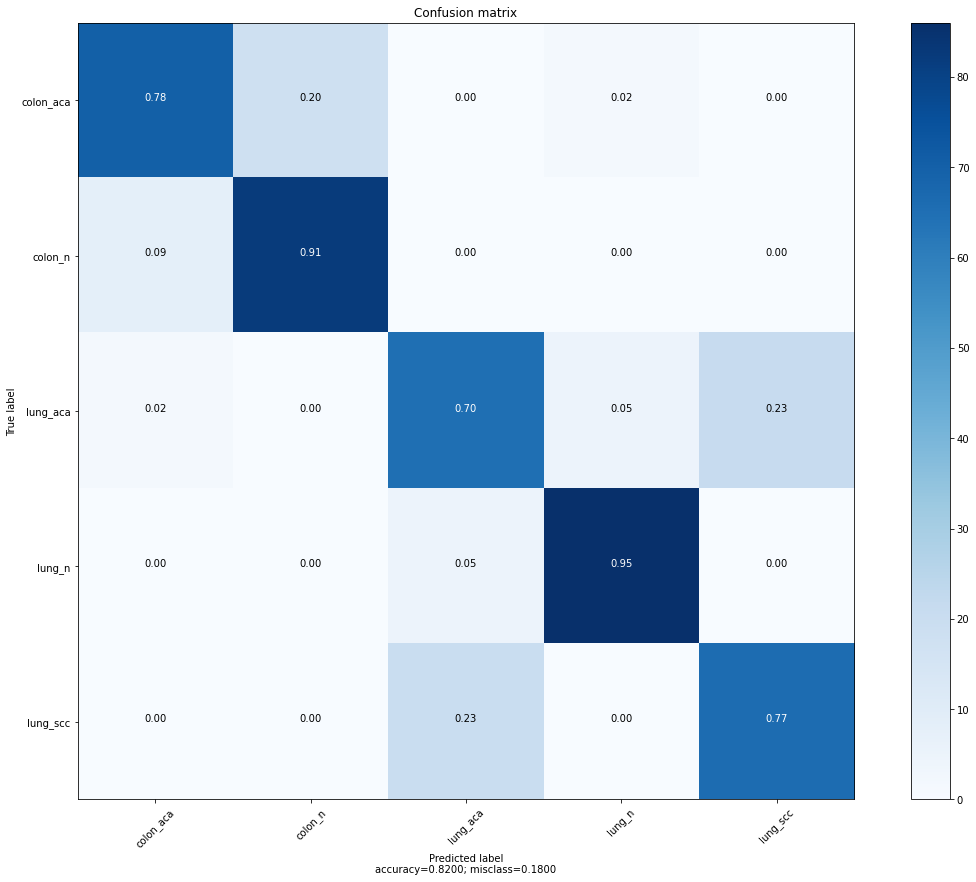

In [21]:
plot_confusion_matrix(confusion_matrix(valid_labels_noisy, predicted_classes), target_names = classes)

In [22]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels_noisy, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.88      0.78      0.82        90
     colon_n       0.82      0.91      0.86        90
    lung_aca       0.72      0.70      0.71        93
      lung_n       0.92      0.95      0.93        91
    lung_scc       0.76      0.77      0.76        86

    accuracy                           0.82       450
   macro avg       0.82      0.82      0.82       450
weighted avg       0.82      0.82      0.82       450



### Comprovem com ho fa el model amb la petita base de dades neta

In [23]:
clean_Y = np.load('labels_reduced_clean.npy')
clean_X = np.load('images_reduced_clean.npy')

clean_X.shape, clean_Y.shape

((500, 120, 120, 3), (500,))

In [24]:
prediction = def_model.predict(clean_X)
pred_labs = []

for i in range(len(prediction)):
    pred_labs.append(np.argmax(prediction[i]))

In [25]:
sum(pred_labs == clean_Y)/len(clean_Y)

0.874

----------------------------------------------------
# Augmentem el soroll

In [26]:
noise_matrix = np.array([[.9,.1,0,0,0],
                         [.1,.9,0,0,0],
                         [0,0,.8,.1,.1],
                         [0,0,.1,.9,0],
                         [0,0,.1,0,.90]])

np.sum(noise_matrix,1) == 1

array([ True,  True,  True,  True,  True])

In [27]:
print_noise_matrix(noise_matrix)
np.random.seed(seed=1)
# Create the noisy labels. This method is exact w.r.t. the noise_matrix.
y_train_w_errors = generate_noisy_labels(dades_Y, noise_matrix)


print("------------------------------------------------------")
print("% d'etiquetes netes: ",sum(y_train_w_errors == dades_Y)/len(dades_Y))

print("------------------------------------------------------")

dades_Y_one_hot_noisy = np.array(pd.get_dummies(y_train_w_errors))
dades_Y_one_hot_noisy = dades_Y_one_hot_noisy.astype('float32')

train_X,valid_X,train_label_noisy,valid_label_noisy = train_test_split(dades_X, dades_Y_one_hot_noisy, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot_noisy)

print(train_X.shape,valid_X.shape,train_label_noisy.shape,valid_label_noisy.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))


 Noise Matrix (aka Noisy Channel) P(s|y) of shape (5, 5)
 p(s|y)	y=0	y=1	y=2	y=3	y=4
	---	---	---	---	---
s=0 |	0.9	0.1	0.0	0.0	0.0
s=1 |	0.1	0.9	0.0	0.0	0.0
s=2 |	0.0	0.0	0.8	0.1	0.1
s=3 |	0.0	0.0	0.1	0.9	0.0
s=4 |	0.0	0.0	0.1	0.0	0.9
	Trace(matrix) = 4.4

------------------------------------------------------
% d'etiquetes netes:  0.88
------------------------------------------------------
(4050, 120, 120, 3) (450, 120, 120, 3) (4050, 5) (450, 5)
------------------------------------------------------
Distribució de les classes :  Counter({0: 900, 3: 900, 1: 900, 4: 900, 2: 900})


In [28]:
# train the network
# H = model.fit(train_X, train_label_noisy, batch_size=BS, epochs=EPOCHS,
#               verbose=1, validation_data=(valid_X, valid_label_noisy))

In [29]:
#model.save("model_88.h5")

In [30]:
def_model = keras.models.load_model('model_88.h5')
test_eval = def_model.evaluate(valid_X,valid_label_noisy, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.958443284034729
Test accuracy: 0.8666666746139526


In [31]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels_noisy = np.argmax(np.round(valid_label_noisy),axis=1)

In [32]:
# acc_loss_plot(H)

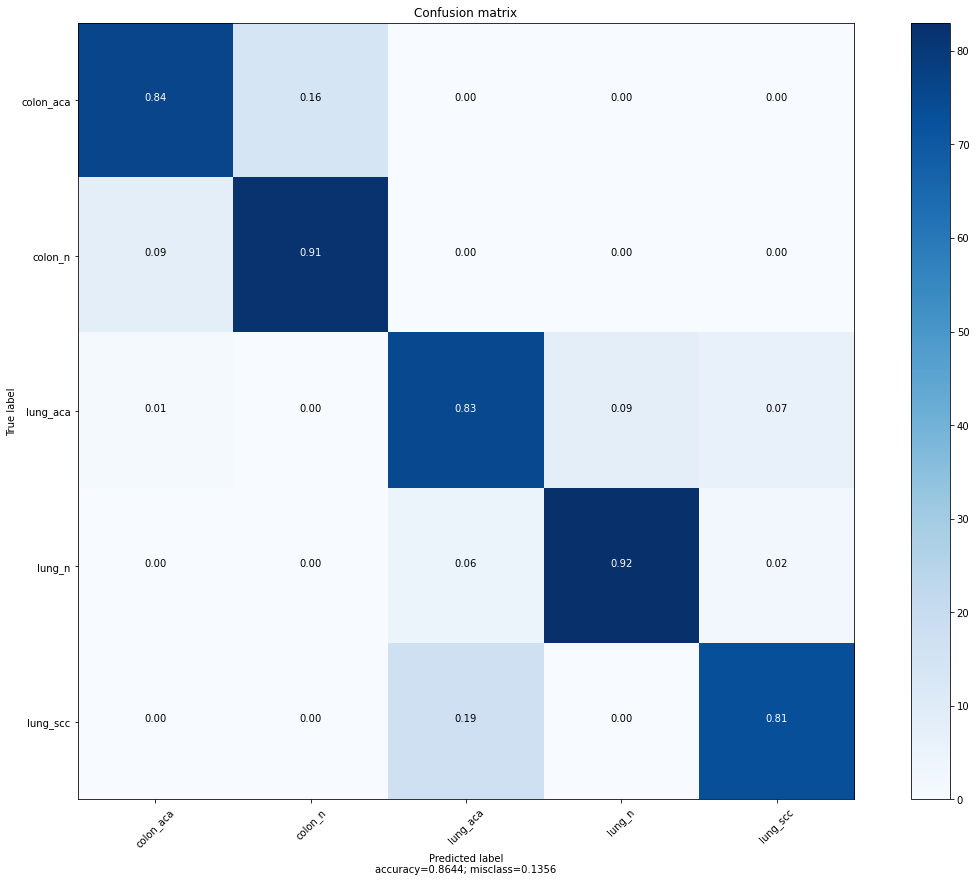

In [33]:
plot_confusion_matrix(confusion_matrix(valid_labels_noisy, predicted_classes), target_names = classes)

In [34]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels_noisy, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.89      0.84      0.87        90
     colon_n       0.85      0.91      0.88        90
    lung_aca       0.77      0.83      0.80        90
      lung_n       0.91      0.92      0.92        90
    lung_scc       0.90      0.81      0.85        90

    accuracy                           0.86       450
   macro avg       0.87      0.86      0.86       450
weighted avg       0.87      0.86      0.86       450



### Comprovem com ho fa el model amb la petita base de dades neta

In [35]:
prediction = def_model.predict(clean_X)
pred_labs = []

for i in range(len(prediction)):
    pred_labs.append(np.argmax(prediction[i]))

In [36]:
sum(pred_labs == clean_Y)/len(clean_Y)

0.85

# Augmentem encara més el soroll

In [37]:
noise_matrix = np.array([[.8,.17,.01,.01,.01],
                         [.17,.8,.01,.01,.01],
                         [.01,.01,.7,.14,.14],
                         [.01,.01,.12,.76,.1],
                         [.01,.01,.17,.01,.8]])

np.sum(noise_matrix,1) == 1

array([ True,  True,  True,  True,  True])

In [38]:
print_noise_matrix(noise_matrix)
np.random.seed(seed=1)
# Create the noisy labels. This method is exact w.r.t. the noise_matrix.
y_train_w_errors = generate_noisy_labels(dades_Y, noise_matrix)


print("------------------------------------------------------")
print("% d'etiquetes netes: ",sum(y_train_w_errors == dades_Y)/len(dades_Y))

print("------------------------------------------------------")

dades_Y_one_hot_noisy = np.array(pd.get_dummies(y_train_w_errors))
dades_Y_one_hot_noisy = dades_Y_one_hot_noisy.astype('float32')

train_X,valid_X,train_label_noisy,valid_label_noisy = train_test_split(dades_X, dades_Y_one_hot_noisy, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot_noisy)

print(train_X.shape,valid_X.shape,train_label_noisy.shape,valid_label_noisy.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))


 Noise Matrix (aka Noisy Channel) P(s|y) of shape (5, 5)
 p(s|y)	y=0	y=1	y=2	y=3	y=4
	---	---	---	---	---
s=0 |	0.8	0.17	0.01	0.01	0.01
s=1 |	0.17	0.8	0.01	0.01	0.01
s=2 |	0.01	0.01	0.7	0.14	0.14
s=3 |	0.01	0.01	0.12	0.76	0.1
s=4 |	0.01	0.01	0.17	0.01	0.8
	Trace(matrix) = 3.86

------------------------------------------------------
% d'etiquetes netes:  0.772
------------------------------------------------------
(4050, 120, 120, 3) (450, 120, 120, 3) (4050, 5) (450, 5)
------------------------------------------------------
Distribució de les classes :  Counter({3: 963, 0: 900, 1: 900, 2: 891, 4: 846})


In [39]:
# train the network
# H = model.fit(train_X, train_label_noisy, batch_size=BS, epochs=EPOCHS,
#               verbose=1, validation_data=(valid_X, valid_label_noisy))

In [40]:
#model.save("model_78.h5")

In [41]:
def_model = keras.models.load_model('model_78.h5')
test_eval = def_model.evaluate(valid_X,valid_label_noisy, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.1232725381851196
Test accuracy: 0.8822222352027893


In [42]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels_noisy = np.argmax(np.round(valid_label_noisy),axis=1)

In [43]:
# acc_loss_plot(H)

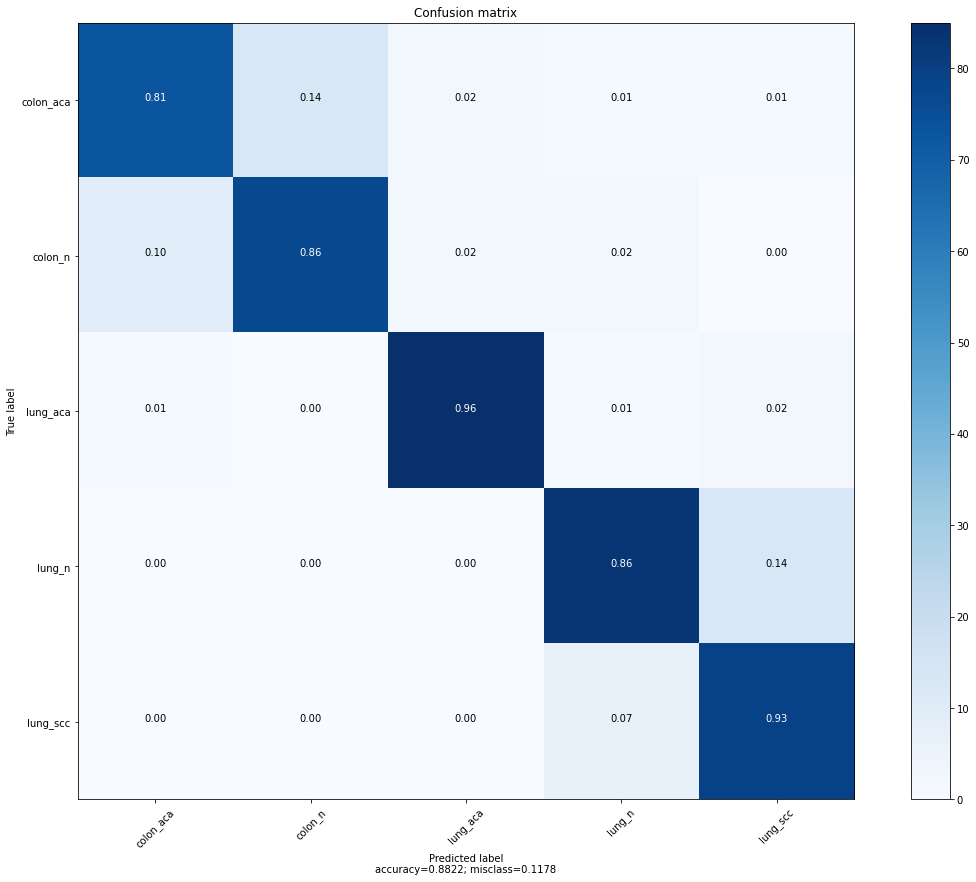

In [44]:
plot_confusion_matrix(confusion_matrix(valid_labels_noisy, predicted_classes), target_names = classes)

In [45]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels_noisy, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.88      0.81      0.84        90
     colon_n       0.86      0.86      0.86        90
    lung_aca       0.96      0.96      0.96        89
      lung_n       0.89      0.86      0.88        96
    lung_scc       0.83      0.93      0.88        85

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450



### Comprovem com ho fa el model amb la petita base de dades neta

In [46]:
prediction = def_model.predict(clean_X)
pred_labs = []

for i in range(len(prediction)):
    pred_labs.append(np.argmax(prediction[i]))

In [47]:
sum(pred_labs == clean_Y)/len(clean_Y)

0.754

# Augmentem encara més el soroll

In [48]:
noise_matrix = np.array([[.7,.2,.04,.03,.03],
                         [.2,.7,.04,.03,.03],
                         [.05,.01,.68,.13,.13],
                         [.01,.02,.12,.7,.15],
                         [.04,.04,.17,.05,.7]])

np.sum(noise_matrix,1) == 1

array([ True,  True,  True,  True,  True])

In [49]:
print_noise_matrix(noise_matrix)
np.random.seed(seed=1)
# Create the noisy labels. This method is exact w.r.t. the noise_matrix.
y_train_w_errors = generate_noisy_labels(dades_Y, noise_matrix)


print("------------------------------------------------------")
print("% d'etiquetes netes: ",sum(y_train_w_errors == dades_Y)/len(dades_Y))

print("------------------------------------------------------")

dades_Y_one_hot_noisy = np.array(pd.get_dummies(y_train_w_errors))
dades_Y_one_hot_noisy = dades_Y_one_hot_noisy.astype('float32')

train_X,valid_X,train_label_noisy,valid_label_noisy = train_test_split(dades_X, dades_Y_one_hot_noisy, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot_noisy)

print(train_X.shape,valid_X.shape,train_label_noisy.shape,valid_label_noisy.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))


 Noise Matrix (aka Noisy Channel) P(s|y) of shape (5, 5)
 p(s|y)	y=0	y=1	y=2	y=3	y=4
	---	---	---	---	---
s=0 |	0.7	0.2	0.04	0.03	0.03
s=1 |	0.2	0.7	0.04	0.03	0.03
s=2 |	0.05	0.01	0.68	0.13	0.13
s=3 |	0.01	0.02	0.12	0.7	0.15
s=4 |	0.04	0.04	0.17	0.05	0.7
	Trace(matrix) = 3.48

------------------------------------------------------
% d'etiquetes netes:  0.696
------------------------------------------------------
(4050, 120, 120, 3) (450, 120, 120, 3) (4050, 5) (450, 5)
------------------------------------------------------
Distribució de les classes :  Counter({3: 954, 1: 927, 0: 900, 4: 864, 2: 855})


In [50]:
# train the network
# H = model.fit(train_X, train_label_noisy, batch_size=BS, epochs=EPOCHS,
#               verbose=1, validation_data=(valid_X, valid_label_noisy))

In [51]:
#model.save("model_70.h5")

In [52]:
def_model = keras.models.load_model('model_70.h5')
test_eval = def_model.evaluate(valid_X,valid_label_noisy, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 3.4661202430725098
Test accuracy: 0.5111111402511597


In [53]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels_noisy = np.argmax(np.round(valid_label_noisy),axis=1)

In [54]:
# acc_loss_plot(H)

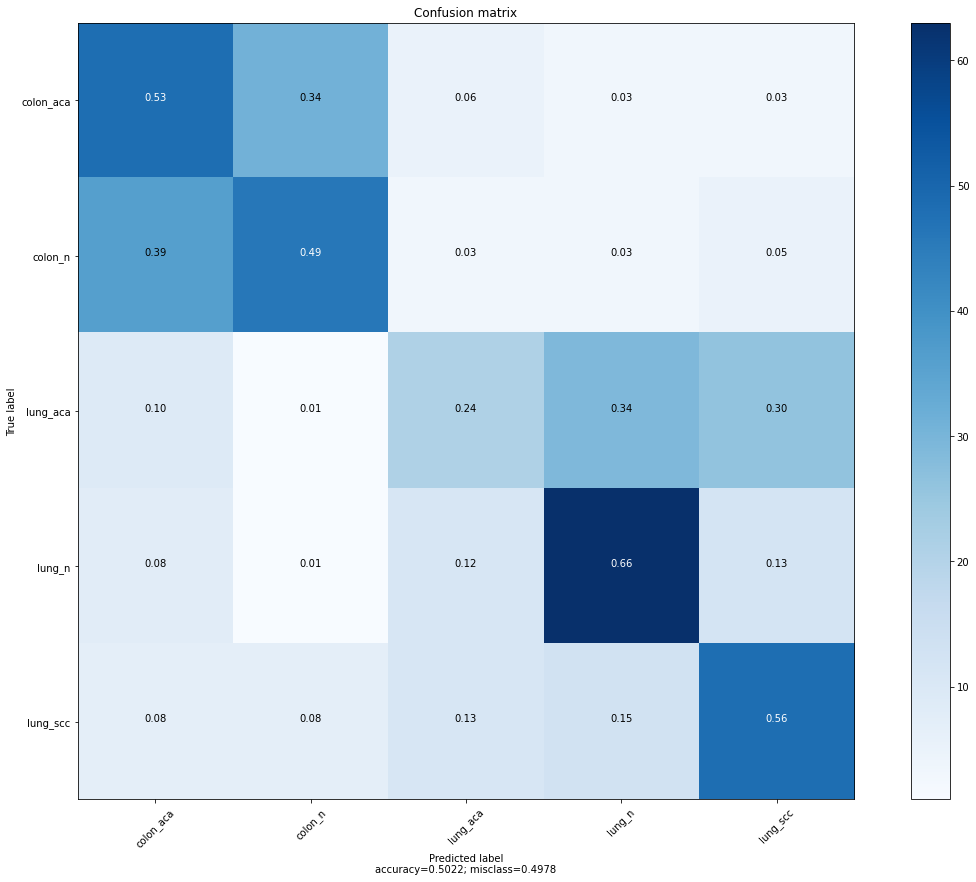

In [55]:
plot_confusion_matrix(confusion_matrix(valid_labels_noisy, predicted_classes), target_names = classes)

In [56]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels_noisy, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.44      0.53      0.48        90
     colon_n       0.53      0.49      0.51        93
    lung_aca       0.41      0.24      0.31        86
      lung_n       0.57      0.66      0.61        95
    lung_scc       0.51      0.56      0.53        86

    accuracy                           0.50       450
   macro avg       0.49      0.50      0.49       450
weighted avg       0.50      0.50      0.49       450



### Comprovem com ho fa el model amb la petita base de dades neta

In [57]:
prediction = def_model.predict(clean_X)
pred_labs = []

for i in range(len(prediction)):
    pred_labs.append(np.argmax(prediction[i]))

In [58]:
sum(pred_labs == clean_Y)/len(clean_Y)

0.642

------------------------------------------------------
# Random labels

In [59]:
random_labels = [random.randint(0, 4) for x in range(dades_X.shape[0])]

In [60]:
random_labels = np.array(random_labels)

In [61]:
print("% d'etiquetes netes: ",sum(random_labels == dades_Y)/len(dades_Y))
print("-------------------------------------------------------")

dades_Y_one_hot_rand = np.array(pd.get_dummies(random_labels))
dades_Y_one_hot_rand = dades_Y_one_hot_rand.astype('float32')

train_X,valid_X,train_label_rand,valid_label_rand = train_test_split(dades_X, dades_Y_one_hot_rand, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot_rand)

print(train_X.shape,valid_X.shape,train_label_rand.shape,valid_label_rand.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))

% d'etiquetes netes:  0.19822222222222222
-------------------------------------------------------
(4050, 120, 120, 3) (450, 120, 120, 3) (4050, 5) (450, 5)
------------------------------------------------------
Distribució de les classes :  Counter({3: 954, 1: 927, 0: 900, 4: 864, 2: 855})


In [62]:
# train the network
# H = model.fit(train_X, train_label_rand, batch_size=BS, epochs=EPOCHS,
#               verbose=1, validation_data=(valid_X, valid_label_rand))

In [63]:
#model.save("model_20.h5")

In [64]:
def_model = keras.models.load_model('model_20.h5')
test_eval = def_model.evaluate(valid_X,valid_label_rand, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.6142371892929077
Test accuracy: 0.19333332777023315


In [65]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels_rand = np.argmax(np.round(valid_label_rand),axis=1)

In [66]:
# acc_loss_plot(H)

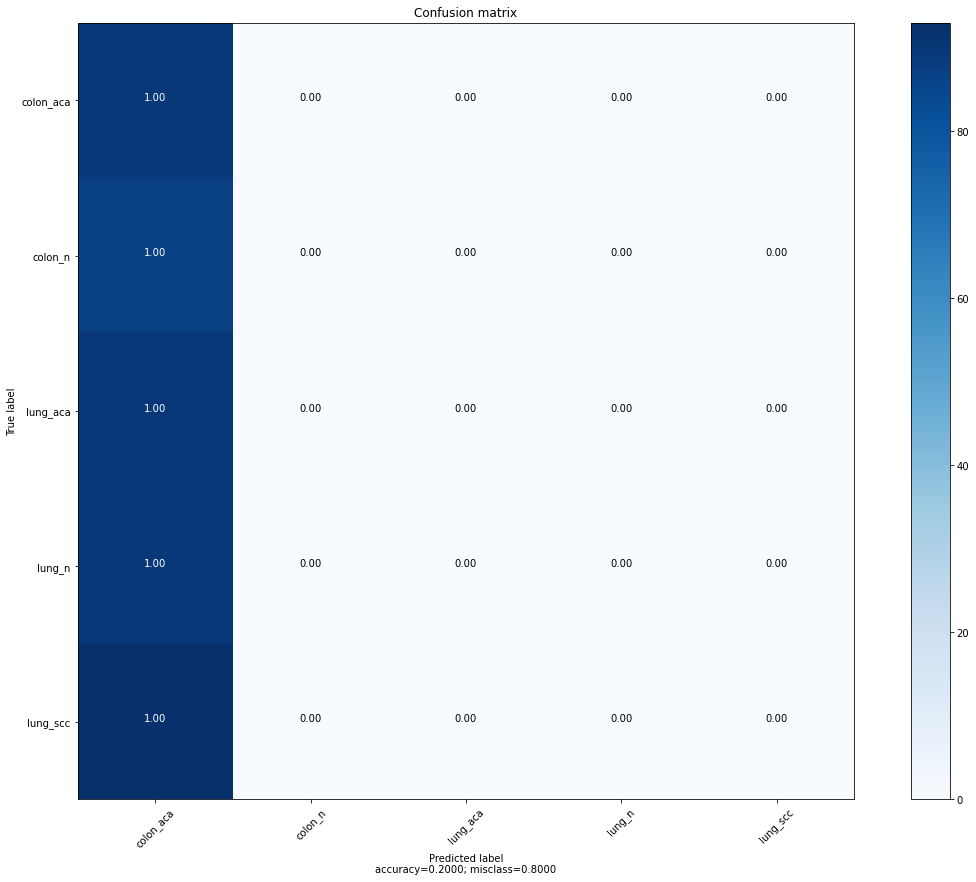

In [67]:
plot_confusion_matrix(confusion_matrix(valid_labels_rand, predicted_classes), target_names = classes)

In [68]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels_rand, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.20      1.00      0.33        90
     colon_n       0.00      0.00      0.00        87
    lung_aca       0.00      0.00      0.00        90
      lung_n       0.00      0.00      0.00        90
    lung_scc       0.00      0.00      0.00        93

    accuracy                           0.20       450
   macro avg       0.04      0.20      0.07       450
weighted avg       0.04      0.20      0.07       450



C:\Users\aidaf\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aidaf\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aidaf\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Comprovem com ho fa el model amb la petita base de dades neta

In [69]:
prediction = def_model.predict(clean_X)
pred_labs = []

for i in range(len(prediction)):
    pred_labs.append(np.argmax(prediction[i]))

In [70]:
sum(pred_labs == clean_Y)/len(clean_Y)

0.274